# Survival analysis of NHANES III data

Data sources:

[NHANES data files](https://wwwn.cdc.gov/nchs/nhanes/nhanes3/datafiles.aspx)

[NHANES mortality files](https://www.cdc.gov/nchs/data-linkage/mortality-public.htm)

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Read the survival data

In [2]:
fname = "NHANES_III_MORT_2011_PUBLIC.dat.gz"
colspecs = [(0, 5), (14, 15), (15, 16), (43, 46), (46, 49)]
names = ["seqn", "eligstat", "mortstat", "permth_int", "permth_exam"]
f = os.path.join("../data", fname)
surv = pd.read_fwf(f, colspecs=colspecs, names=names, compression="gzip")

Read the interview/examination data

In [3]:
colspecs = [(0, 5), (14, 15), (17, 19), (28, 31), (33, 34), (32, 33), (34, 35), (35, 41)]
names = ["seqn", "sex", "age", "county", "urbanrural", "state", "region", "poverty"]
f = os.path.join("../data", "adult.dat.gz")
df = pd.read_fwf(f, colspecs=colspecs, names=names, compression="gzip")
df = pd.merge(surv, df, left_on="seqn", right_on="seqn")

Recode region with text labels

In [4]:
df["region"] = df.region.replace({1: "NE", 2: "MW", 3: "S", 4: "W"})

These are variables that may predict mortality.

In [5]:
df["poverty"] = df["poverty"].replace({888888: np.nan})
df["female"] = (df.sex == 2).astype(np.int)
df["rural"] = (df.urbanrural == 2).astype(np.int)

Calculate the age in months at study entry (NHANES interview)

In [6]:
df["age_months"] = 12 * df.age

Calculate the age in months at final status determination (death or censoring)

In [7]:
df["end"] = df.age_months + df.permth_int

It is possible to do something more sophisticated about missing data, but here we
will do a complete case analysis.

In [8]:
df = df.dropna()

SurvfuncRight can't handle 0 survival times

In [9]:
df = df.loc[df.end > df.age_months]

The hazard function is the derivative of -log(S(t)), where S(t) is the
survival function.  Here we calculate the derivative numerically using
second differences. This tends to produce a noisy estimate of the derivative,
so we smooth it below with local polynomial smoothing.

In [10]:
def hazard(sf):
    tm = s.surv_times
    pr = s.surv_prob
    ii = (pr > 0)
    tm = tm[ii]
    pr = pr[ii]
    lpr = np.log(pr)
    return tm[0:-1], -np.diff(lpr) / np.diff(tm)

Plot the hazard functions for women and men.  These are unadjusted hazard functions,
i.e. they describe the hazard for all people at a given age.

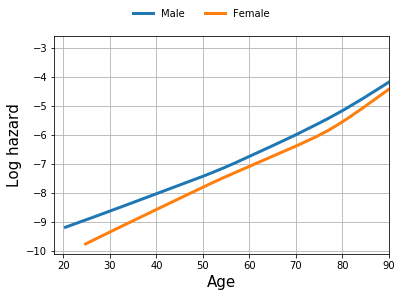

In [11]:
plt.grid(True)
sex = {0: "Male", 1: "Female"}
for female in (0, 1):
    ii = df.female == female
    s = sm.SurvfuncRight(df.loc[ii, "end"], df.loc[ii, "mortstat"], entry=df.loc[ii, "age_months"])
    tm, hz = hazard(s)
    ha = sm.nonparametric.lowess(np.log(hz), tm/12)
    plt.plot(ha[:, 0], ha[:, 1], lw=3, label=sex[female])
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "upper center", ncol=2)
leg.draw_frame(False)
plt.xlabel("Age", size=15)
plt.ylabel("Log hazard", size=15)
_ = plt.xlim(18, 90)

Plot "reverse survival functions" to get a sense of the follow up time.

Text(0, 0.5, 'Probability not censored')

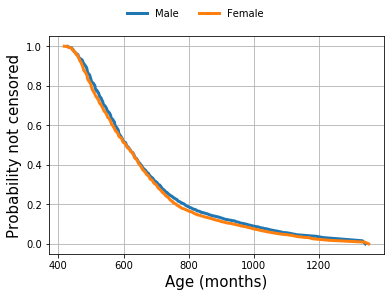

In [12]:
plt.grid(True)
sex = {0: "Male", 1: "Female"}
for female in (0, 1):
    ii = df.female == female
    s = sm.SurvfuncRight(df.loc[ii, "end"], 1 - df.loc[ii, "mortstat"], entry=df.loc[ii, "age_months"])
    plt.plot(s.surv_times, s.surv_prob, lw=3, label=sex[female])
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "upper center", ncol=2)
leg.draw_frame(False)
plt.xlabel("Age (months)", size=15)
plt.ylabel("Probability not censored", size=15)

Here is another reverse survival function, looking here at follow-up time
rather than age.

Text(0, 0.5, 'Probability not censored')

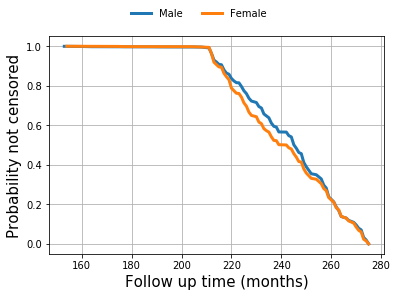

In [13]:
plt.grid(True)
sex = {0: "Male", 1: "Female"}
for female in (0, 1):
    ii = df.female == female
    t = df.loc[ii, "end"]- df.loc[ii, "age_months"]
    s = sm.SurvfuncRight(t, 1 - df.loc[ii, "mortstat"])
    plt.plot(s.surv_times, s.surv_prob, lw=3, label=sex[female])
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "upper center", ncol=2)
leg.draw_frame(False)
plt.xlabel("Follow up time (months)", size=15)
plt.ylabel("Probability not censored", size=15)

Fit a proportional hazards regression model, using sex, urbanicity, and
poverty status to explain the variation in life span.

In [14]:
fml = "end ~ female + rural + region + poverty"
model1 = sm.PHReg.from_formula(fml, status="mortstat", entry=df.age_months,
                               data=df)
result1 = model1.fit()
print(result1.summary())

                          Results: PHReg
Model:                     PH Reg         Sample size:        7361
Dependent variable:        end            Num. events:        2105
Ties:                      Breslow                                
------------------------------------------------------------------
              log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------
region[T.NE] -0.0879    0.0669 0.9158 -1.3138 0.1889 0.8033 1.0442
region[T.S]  -0.0538    0.0743 0.9476 -0.7245 0.4688 0.8192 1.0961
region[T.W]  -0.1372    0.0634 0.8718 -2.1641 0.0305 0.7699 0.9871
female       -0.3856    0.0442 0.6800 -8.7196 0.0000 0.6236 0.7416
rural        -0.0089    0.0685 0.9911 -0.1303 0.8963 0.8666 1.1335
poverty      -0.1044    0.0128 0.9009 -8.1307 0.0000 0.8785 0.9238
Confidence intervals are for the hazard ratios
7361 observations have positive entry times


Fit the same model as above, not stratifying by state of residence.

In [15]:
fml = "end ~ female + rural + poverty"
model2 = sm.PHReg.from_formula(fml, status="mortstat", entry=df.age_months,
                               strata=df.state, data=df)
result2 = model2.fit()
print(result2.summary())

                       Results: PHReg
Model:                  PH Reg     Num strata:          8    
Dependent variable:     end        Min stratum size:    154  
Ties:                   Breslow    Max stratum size:    3612 
Sample size:            7320       Avg stratum size:    920.1
Num. events:            2105                                 
-------------------------------------------------------------
         log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-------------------------------------------------------------
female  -0.3945    0.0446 0.6740 -8.8481 0.0000 0.6177 0.7356
rural   -0.0157    0.0714 0.9845 -0.2194 0.8263 0.8559 1.1323
poverty -0.1048    0.0131 0.9005 -8.0205 0.0000 0.8778 0.9239
Confidence intervals are for the hazard ratios
7361 observations have positive entry times


Now stratify instead on county.  Note that the sex and poverty coefficients
are similar to what we saw above, but the urbanicity coefficient (rural)
changes substantially.  Below, we compare people living in rural areas to
people living in non-rural areas, while living in the same county.  Above,
we compare people living in rural areas to people living in non-rural areas
without the requirement that they live in the same county.

In [16]:
fml = "end ~ female + rural + poverty"
model3 = sm.PHReg.from_formula(fml, status="mortstat", entry=df.age_months,
                               strata=df.county, data=df)
result3 = model3.fit()
print(result3.summary())

                       Results: PHReg
Model:                  PH Reg     Num strata:          31   
Dependent variable:     end        Min stratum size:    126  
Ties:                   Breslow    Max stratum size:    937  
Sample size:            7169       Avg stratum size:    237.5
Num. events:            2105                                 
-------------------------------------------------------------
         log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-------------------------------------------------------------
female  -0.4131    0.0457 0.6616 -9.0439 0.0000 0.6049 0.7235
rural    0.1159    0.1610 1.1229  0.7199 0.4716 0.8191 1.5394
poverty -0.1093    0.0137 0.8965 -7.9949 0.0000 0.8728 0.9208
Confidence intervals are for the hazard ratios
7361 observations have positive entry times
